# Implementazione algoritmo
* 6/3/2021




## Cose da fare
1. Implementazione dell'algoritmo sviluppato dai medici
2. Induzione di un decision tree 
3. Giocare con gli hyperparamethers del decision tree indotto e riflettere sulle regole che esso utilizza per la classificazione

# Criteri inclusione pazienti nella popolazione studiata
1. Pazienti affetti da un sospettato tumore alla parotide che si sono poi sottoposti ad operazione
2. Pazienti di età non inferiore ai 18 anni
3. Pazienti che si sono già sottoposti o verranno sottoposti a MRI

# Criteri esclusione pazienti dalla popolazione studiata
1. Lesioni non-neoplastiche rilevate con esame istologico
2. Pazienti che hanno rifiutato operazioni chirurgiche
3. Lesioni molto piccole (<1 cm), lesioni cistiche (falsi positivi durante risonanza)


# Design dell'algoritmo

## Lesione parotidea

## Primo step: metodi convenzionali e MRI
Utilizzo di tecniche istologiche per determinare se sono presenti segni macroscopici di malignità (hypointensity, eterogeneità, infiltrazione in altre strutture). Se sono presenti segni di malignità macroscopici, ad esempio se c'è inflitrazione in strutture adiacenti, allora il tumore è classificato come maligno.

## Secondo step: diffusion weighted imaging
Misura dell'ADC. Se inferiore a 0.6 allora il tumore è classificato come linfoma. Se superiore 1.3 è classificato come benigno. Se è il valore dell'ADC è compreso tra questi due valori si prosegue con l'algoritmo

## Terzo step: perfusion studies
Analisi del tipo di curva TIC. Curva DCE (tempo che la lesione impiega per tornare nella condizione iniziale dopo l'im pulso). La curva può essere crescente (tipo A), decrescente (tipo B), pseudocostante (tipo C) o indefinita (tipo C).

# Output algoritmo
1. Malignant high-grade
2. Lymphoma
3. Pleomprphic adenoma
4. Warthin tumor
5. Benign tumor
6. Indeterminet lesion
7. Malignant tumor

# T2
Nel dataset 0 codifica un valore T2 alto, 1 codifica un valore basso. 

# Obbiettivo
Eliminare la classe indeterminato, considerare solo le prime 5 classi.

Per iniziare implemento il loro algoritmo. E vedo se l'output di questo algoritmo corrisponde all'output fornito


L'id del paziente non è feature da prendere in considerazione per la classificazione.
Da età a t2 sono feature, quello che segue è il loro output

Nell'implementazione del loro algoritmo tengo conto delle feature sopra indicate ma non dell'età.

Il codice istologico rappresenta la vera categoria del tumore, derivato dall'analisi delle sue cellule.

6 e 7 sono categorie indeterminate per algo (?)
1 è carcinoma (?)


# Assunzioni sugli alberi
Le etichette 1 e 6 sono da unire (?)
Tu lavori sull'albero di decisione e giochi sulla sua profondità massima
Ogni foglia deve avere almeno due pazienti
L'albero non deve essere troppo profondo--> se è convoluto significa che sta imparando a memoria, non impara relazione tra le features


cross validation-->dividi dati in 5 blocchi da 20-->calcola errore sul gruppo sui cui non alleni albero

sklearn.model_selection per calcolo errore

Puoi provare anche a fare 3 LOO. 3 samples messi da parte, alleni sul resto e calcoli errore sui 3 .

Una volta indotti gli alberi visualizzali per capire quali regole applicano per la classificazione.
Se hai multiple domande sulla stessa feature-->potrebbe essere overfitting

Per l'induzione degli alberi non usare gini, usa l'entropia

Tieni in considerazione max_depth --> quante regole puoi concatenare --> non troppo elevata per evitare overfitting --> se è troppo profondo apprende rumore

Ogni foglia deve avere almeno due campioni --> setta min_sample_leaf opportunamente

Ragiona su cosa l'albero ha appreso e confrontalo con l'algoritmo dato 

In [1]:
#Carico il dataset e mantengo solo le features rilevanti per l'implementazione dell'algoritmo e l'induzione degli
#alberi di decisione. In particolare elimino i nomi e i cognomi dei pazienti per privacy.
#Inoltre escludo dal dataset le entry dove le feature "Escludere" è settata ad 1.
import pandas as pd

df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2', 'Output Algoritmo','COD ISTO']]
df.head(10)

,Segni macro malignità,ADC,TIC type,T2,Output Algoritmo,COD ISTO
0,0,"1,6",A,1,3,3
1,0,1,B,0,4,4
2,0,"1,2",C,0,6,3
3,0,"0,77",B,1,4,4
4,0,"0,8",C,1,7,1
5,0,"1,4",A,1,3,6
6,1,"0,7",C,1,1,1
7,0,"0,9",B,1,4,4
8,0,"0,7",B,1,4,4
9,0,"0,8",B,1,4,4


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Segni macro malignità  107 non-null    int64 
 1   ADC                    107 non-null    object
 2   TIC type               107 non-null    object
 3   T2                     107 non-null    int64 
 4   Output Algoritmo       107 non-null    int64 
 5   COD ISTO               107 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 5.1+ KB


In [3]:
# Non sembrano esserci celle null nell'intero dataframe
#cambio il tipo dei valori ADC da str a float, per manipolarli meglio
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)
df.head(10)

,Segni macro malignità,ADC,TIC type,T2,Output Algoritmo,COD ISTO
0,0,1.60,A,1,3,3
1,0,1.00,B,0,4,4
2,0,1.20,C,0,6,3
3,0,0.77,B,1,4,4
4,0,0.80,C,1,7,1
5,0,1.40,A,1,3,6
6,1,0.70,C,1,1,1
7,0,0.90,B,1,4,4
8,0,0.70,B,1,4,4
9,0,0.80,B,1,4,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Segni macro malignità  107 non-null    int64  
 1   ADC                    107 non-null    float64
 2   TIC type               107 non-null    object 
 3   T2                     107 non-null    int64  
 4   Output Algoritmo       107 non-null    int64  
 5   COD ISTO               107 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 5.1+ KB


In [5]:
#valuto la distribuzione dei tipi di tumore
df['COD ISTO'].value_counts()

3    53
4    27
1    12
5     6
2     5
6     4
Name: COD ISTO, dtype: int64

In [6]:
#implemento l'algoritmo definito dai medici
#mantenendo per ora tutte e 7 le categorie di tumori

In [7]:
#Recap classificazione
#1-->Malignant high grade
#2-->Lymphoma
#3-->Pleomorphic adenoma
#4-->Warthin tumor
#5-->benign tumor
#6-->indetermined (da escludere poi)
#7-->malignant (da escludere poi)


#Implementazione 

def algoritmo(input):
    '''
    questa funzione prende come input una una riga del dataframe,
    cioè i valori delle feature che riguardano un dato paziente
    '''
    
    #valutazione presenza segni macroscopici di malignità
    
    if input['Segni macro malignità'] == 1: 
    
        return 1  #malignant high-grade tumor
    
    #valutazione valori ADC
    
    if input['ADC'] <= 0.6:
        return 2  #lymphoma
    
    if input['ADC'] >= 1.3:
        return 3  #pleomorphic adenoma/cyst
    
    #sospetto di malignità
    
    if input['TIC type'] == 'A':
        if input['T2'] == 0:
            return 5 #benign tumor
        else:
            return 6 #indeterminate lesion
        
    elif input['TIC type'] == 'B':
        return 4  #warthin tumor
    
    else:
        if input['T2'] == 0:
            return 6 #indeterminate lesion
        else:
            return 7 #malignant tumor

In [8]:
#verifico se la mia implementazione dell'algoritmo produce gli stessi output riportati nel dataset
(df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']].apply(algoritmo, axis = 1) 
 == df['Output Algoritmo']).value_counts()

True    107
dtype: int64

In [9]:
#ho confermato che la mia implementazione è corretta, o che almeno buona come l'implementazione usata dai medici 
#per compilare il dataset

In [10]:
#ora valuto se l'output dell'algoritmo coincide con l'effettiva categoria dei tumori
#
(df['Output Algoritmo'] == df['COD ISTO']).value_counts()

True     85
False    22
dtype: int64

In [11]:
#ripeto intepretando la label 7 usata dall'algoritmo come se fosse 1
algo_outputs = df['Output Algoritmo'].copy()
algo_outputs = [x if x != 7 else 1 for x in algo_outputs]
(algo_outputs == df['COD ISTO']).value_counts()

True     89
False    18
Name: COD ISTO, dtype: int64

In [12]:
#valuto la distribuzione dell'output dell'algoritmo
df['Output Algoritmo'].value_counts()

3    47
4    27
6    12
1     8
7     6
2     5
5     2
Name: Output Algoritmo, dtype: int64

In [13]:
#in ambo i casi, l'algoritmo non è stato in grado di classificare correttamente tutti i tumori.
#inoltre osservo che nessun tumore è stato effettivamente classificato come 7 (maligno), ciò rafforza l'idea di aggregare
#la categoria 7 alla categoria 1

In [14]:
#misuro le performance dell'algoritmo sul dataset usando gli stessi parametri impiegati dai medici 
#ed eseguo un confronto


In [15]:
#misura accuratezza lungo tutte le classi (ad eccezione della 7)
from sklearn.metrics import classification_report
print(classification_report(df['COD ISTO'], algo_outputs))

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      1.00      1.00         5
           3       0.91      0.81      0.86        53
           4       1.00      1.00      1.00        27
           5       0.00      0.00      0.00         6
           6       0.17      0.50      0.25         4

    accuracy                           0.83       107
   macro avg       0.66      0.72      0.67       107
weighted avg       0.85      0.83      0.84       107



In [16]:
#l'accuratezza è la medesima di quella comunicata dai medici
#ora valuto sensitività e specificità

#per fare ciò fondo le classi in due : 0 per benigni (3,4,5,6), 1 per maligni (1,2)

In [17]:
algo_outputs = [0 if (x != 1 and x!=2) else 1 for x in df['Output Algoritmo']]
bin_cod_isto = [0 if (x != 1 and x!=2) else 1 for x in df['COD ISTO']]
print(classification_report(bin_cod_isto, algo_outputs))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        90
           1       1.00      0.76      0.87        17

    accuracy                           0.96       107
   macro avg       0.98      0.88      0.92       107
weighted avg       0.96      0.96      0.96       107



In [18]:
#recall of positive class == sensitivity ---> 0.76
#recal of negative class = specificity ----> 1

In [19]:
#se condero 6 come maligno
algo_outputs = [0 if (x != 1 and x!=2 and x!=6) else 1 for x in df['Output Algoritmo']]
bin_cod_isto = [0 if (x != 1 and x!=2 and x!=6) else 1 for x in df['COD ISTO']]
print(classification_report(bin_cod_isto, algo_outputs))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        86
           1       0.60      0.71      0.65        21

    accuracy                           0.85       107
   macro avg       0.76      0.80      0.78       107
weighted avg       0.86      0.85      0.86       107



In [20]:
#faccio peggio, assumo che i medici non abbiano fatto questa incorporazione di 6 in maligno

In [21]:
#Ora tento di indurre un albero di decisione a partire dall'intero dataset 

#elimino la categoria 6 e 7 in questa induzione, cioè elimino alcune entry dal dataset 
#ragionevole perchè elimino solo 4 entry indeterminate
#quindi rimango con un centinaio di entry

df_trees = df.loc[df['COD ISTO'] != 6]
df_trees.reset_index(inplace = True)


#devo inoltre ricordare che i decision tree di skelearn lavorano solo con feature numeriche.
#applico one hot encoding sulla feature categorica TIC type
y = df_trees['COD ISTO'].copy()



X_not_encoded = df_trees[['Segni macro malignità', 'ADC', 'TIC type', 'T2']]
X_not_encoded.head()

,Segni macro malignità,ADC,TIC type,T2
0,0,1.60,A,1
1,0,1.00,B,0
2,0,1.20,C,0
3,0,0.77,B,1
4,0,0.80,C,1


In [22]:
#Devo gestire il fatto che sklearn manipola solo variabili numeriche e non categoriche
X_not_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Segni macro malignità  103 non-null    int64  
 1   ADC                    103 non-null    float64
 2   TIC type               103 non-null    object 
 3   T2                     103 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.3+ KB


In [23]:
#applico conversione con one-hot-encoding get_dummies da pandas
X = pd.get_dummies(X_not_encoded, columns = ['TIC type'])
X

,Segni macro malignità,ADC,T2,TIC type_A,TIC type_B,TIC type_C
0,0,1.60,1,1,0,0
1,0,1.00,0,0,1,0
2,0,1.20,0,0,0,1
3,0,0.77,1,0,1,0
4,0,0.80,1,0,0,1
...,...,...,...,...,...,...
98,0,1.45,0,0,0,1
99,0,1.90,0,1,0,0
100,0,1.10,0,0,1,0
101,0,1.20,0,0,1,0


In [24]:
y = pd.Series(y)
y.value_counts()

3    53
4    27
1    12
5     6
2     5
Name: COD ISTO, dtype: int64

In [25]:
import numpy as np

classes = np.sort(y.unique()).astype(str)
features = X.columns

[Text(225.76973684210526, 259.44545454545454, 'ADC <= 0.6\nentropy = 2.322\nsamples = 103\nvalue = [20.6, 20.6, 20.6, 20.6, 20.6]\nclass = 2'),
 Text(181.7171052631579, 234.73636363636365, 'entropy = 0.0\nsamples = 5\nvalue = [0.0, 20.6, 0.0, 0.0, 0.0]\nclass = 2'),
 Text(269.82236842105266, 234.73636363636365, 'TIC type_B <= 0.5\nentropy = 2.0\nsamples = 98\nvalue = [20.6, 0.0, 20.6, 20.6, 20.6]\nclass = 5'),
 Text(225.76973684210526, 210.02727272727273, 'TIC type_C <= 0.5\nentropy = 1.585\nsamples = 71\nvalue = [20.6, 0.0, 20.6, 0.0, 20.6]\nclass = 5'),
 Text(88.10526315789474, 185.3181818181818, 'ADC <= 0.875\nentropy = 0.0\nsamples = 41\nvalue = [0.0, 0.0, 15.936, 0.0, 0.0]\nclass = 3'),
 Text(44.05263157894737, 160.60909090909092, 'entropy = 0.0\nsamples = 1\nvalue = [0.0, 0.0, 0.389, 0.0, 0.0]\nclass = 3'),
 Text(132.1578947368421, 160.60909090909092, 'entropy = 0.0\nsamples = 40\nvalue = [0.0, 0.0, 15.547, 0.0, 0.0]\nclass = 3'),
 Text(363.4342105263158, 185.3181818181818, 'ADC 

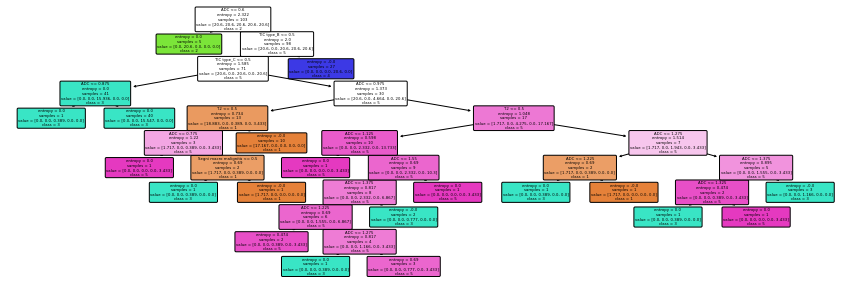

In [26]:
#induco un albero di decisione lasciando tutti gli hyper paramhether con i valori di default
from sklearn import tree
import matplotlib.pyplot as plt
seed = 42
clf = tree.DecisionTreeClassifier(random_state = seed, class_weight = 'balanced', criterion = 'entropy')
clf = clf.fit(X,y)

plt.figure(figsize=(15,5))
tree.plot_tree(clf,
               feature_names = features,
               class_names = classes, filled = True, rounded = True)

[Text(334.8, 453.0, 'ADC <= 0.6\nentropy = 2.322\nsamples = 103\nvalue = [20.6, 20.6, 20.6, 20.6, 20.6]\nclass = 2'),
 Text(167.4, 271.8, 'entropy = 0.0\nsamples = 5\nvalue = [0.0, 20.6, 0.0, 0.0, 0.0]\nclass = 2'),
 Text(502.20000000000005, 271.8, 'TIC type_B <= 0.5\nentropy = 2.0\nsamples = 98\nvalue = [20.6, 0.0, 20.6, 20.6, 20.6]\nclass = 5'),
 Text(334.8, 90.59999999999997, 'entropy = 1.585\nsamples = 71\nvalue = [20.6, 0.0, 20.6, 0.0, 20.6]\nclass = 5'),
 Text(669.6, 90.59999999999997, 'entropy = -0.0\nsamples = 27\nvalue = [0.0, 0.0, 0.0, 20.6, 0.0]\nclass = 4')]

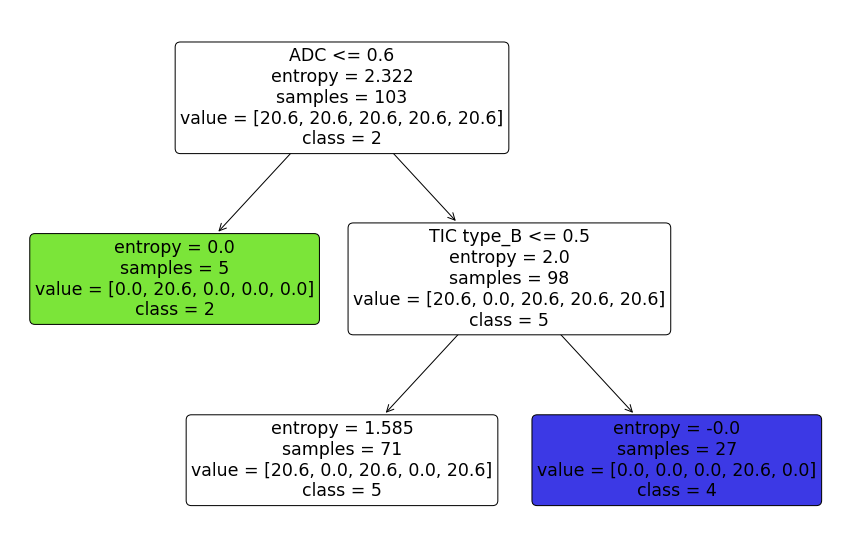

In [27]:
#l'albero ottenuto è decisamente convoluto, provo a limitare la profondità a 2
clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 2, min_samples_leaf = 2,
                                  class_weight = 'balanced', criterion = 'entropy')
clf = clf.fit(X,y)

plt.figure(figsize=(15,10))
tree.plot_tree(clf,
               feature_names = features,
               class_names = classes, filled = True, rounded = True)

[Text(334.8, 475.65000000000003, 'ADC <= 0.6\nentropy = 2.322\nsamples = 103\nvalue = [20.6, 20.6, 20.6, 20.6, 20.6]\nclass = 2'),
 Text(167.4, 339.75, 'entropy = 0.0\nsamples = 5\nvalue = [0.0, 20.6, 0.0, 0.0, 0.0]\nclass = 2'),
 Text(502.20000000000005, 339.75, 'TIC type_B <= 0.5\nentropy = 2.0\nsamples = 98\nvalue = [20.6, 0.0, 20.6, 20.6, 20.6]\nclass = 5'),
 Text(334.8, 203.85000000000002, 'TIC type_C <= 0.5\nentropy = 1.585\nsamples = 71\nvalue = [20.6, 0.0, 20.6, 0.0, 20.6]\nclass = 5'),
 Text(167.4, 67.94999999999999, 'entropy = 0.0\nsamples = 41\nvalue = [0.0, 0.0, 15.936, 0.0, 0.0]\nclass = 3'),
 Text(502.20000000000005, 67.94999999999999, 'entropy = 1.373\nsamples = 30\nvalue = [20.6, 0.0, 4.664, 0.0, 20.6]\nclass = 5'),
 Text(669.6, 203.85000000000002, 'entropy = -0.0\nsamples = 27\nvalue = [0.0, 0.0, 0.0, 20.6, 0.0]\nclass = 4')]

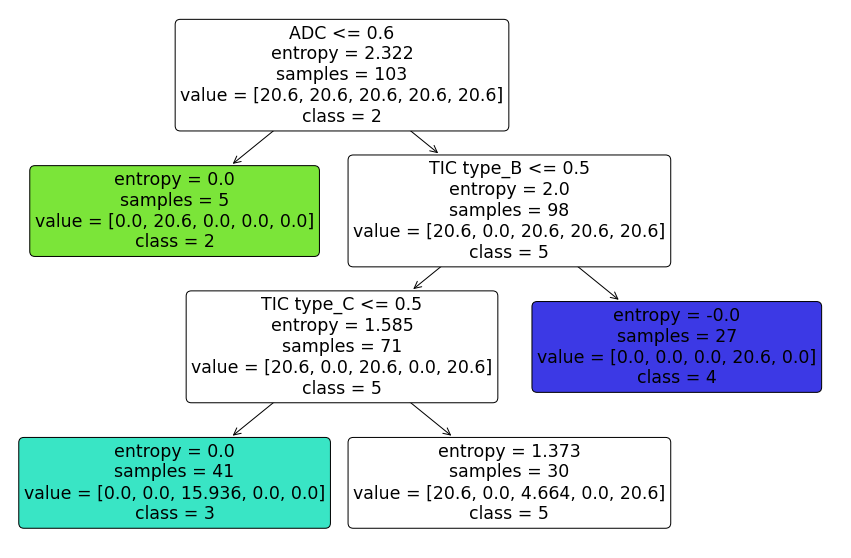

In [28]:
#l'albero ottenuto è decisamente convoluto, provo a limitare la profondità a 3
clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 3, min_samples_leaf = 2,
                                  class_weight = 'balanced', criterion = 'entropy')
clf = clf.fit(X,y)

plt.figure(figsize=(15,10))
tree.plot_tree(clf,
               feature_names = features,
               class_names = classes, filled = True, rounded = True)

[Text(418.5, 489.24, 'ADC <= 0.6\nentropy = 2.322\nsamples = 103\nvalue = [20.6, 20.6, 20.6, 20.6, 20.6]\nclass = 2'),
 Text(313.875, 380.52000000000004, 'entropy = 0.0\nsamples = 5\nvalue = [0.0, 20.6, 0.0, 0.0, 0.0]\nclass = 2'),
 Text(523.125, 380.52000000000004, 'TIC type_B <= 0.5\nentropy = 2.0\nsamples = 98\nvalue = [20.6, 0.0, 20.6, 20.6, 20.6]\nclass = 5'),
 Text(418.5, 271.8, 'TIC type_C <= 0.5\nentropy = 1.585\nsamples = 71\nvalue = [20.6, 0.0, 20.6, 0.0, 20.6]\nclass = 5'),
 Text(209.25, 163.08000000000004, 'ADC <= 1.025\nentropy = 0.0\nsamples = 41\nvalue = [0.0, 0.0, 15.936, 0.0, 0.0]\nclass = 3'),
 Text(104.625, 54.360000000000014, 'entropy = 0.0\nsamples = 2\nvalue = [0.0, 0.0, 0.777, 0.0, 0.0]\nclass = 3'),
 Text(313.875, 54.360000000000014, 'entropy = 0.0\nsamples = 39\nvalue = [0.0, 0.0, 15.158, 0.0, 0.0]\nclass = 3'),
 Text(627.75, 163.08000000000004, 'ADC <= 0.975\nentropy = 1.373\nsamples = 30\nvalue = [20.6, 0.0, 4.664, 0.0, 20.6]\nclass = 5'),
 Text(523.125, 54.3

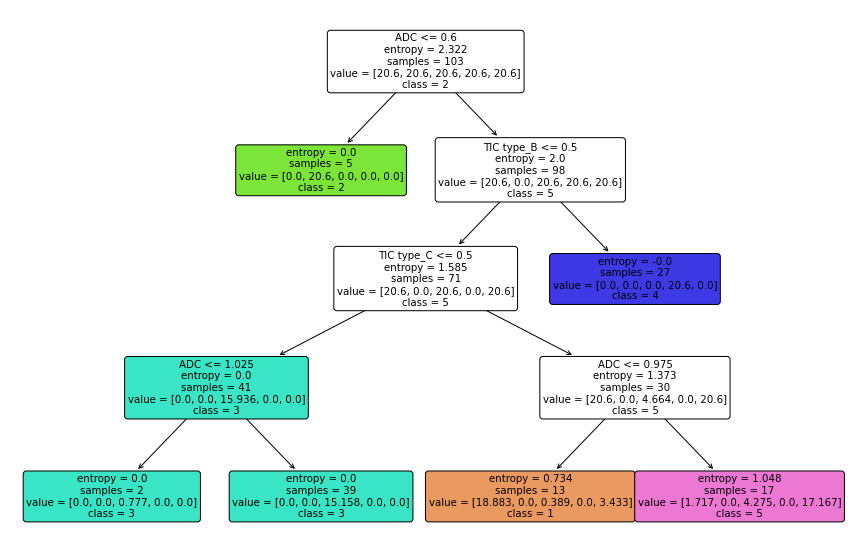

In [29]:
#profondità 4
clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 4, min_samples_leaf = 2,
                                  class_weight = 'balanced', criterion = 'entropy')
clf = clf.fit(X,y)

plt.figure(figsize=(15,10))
tree.plot_tree(clf,
               feature_names = features,
               class_names = classes, filled = True, rounded = True)


[Text(342.40909090909093, 498.3, 'ADC <= 0.6\nentropy = 2.322\nsamples = 103\nvalue = [20.6, 20.6, 20.6, 20.6, 20.6]\nclass = 2'),
 Text(266.3181818181818, 407.70000000000005, 'entropy = 0.0\nsamples = 5\nvalue = [0.0, 20.6, 0.0, 0.0, 0.0]\nclass = 2'),
 Text(418.5, 407.70000000000005, 'TIC type_B <= 0.5\nentropy = 2.0\nsamples = 98\nvalue = [20.6, 0.0, 20.6, 20.6, 20.6]\nclass = 5'),
 Text(342.40909090909093, 317.1, 'TIC type_C <= 0.5\nentropy = 1.585\nsamples = 71\nvalue = [20.6, 0.0, 20.6, 0.0, 20.6]\nclass = 5'),
 Text(152.1818181818182, 226.5, 'ADC <= 1.025\nentropy = 0.0\nsamples = 41\nvalue = [0.0, 0.0, 15.936, 0.0, 0.0]\nclass = 3'),
 Text(76.0909090909091, 135.89999999999998, 'entropy = 0.0\nsamples = 2\nvalue = [0.0, 0.0, 0.777, 0.0, 0.0]\nclass = 3'),
 Text(228.27272727272728, 135.89999999999998, 'entropy = 0.0\nsamples = 39\nvalue = [0.0, 0.0, 15.158, 0.0, 0.0]\nclass = 3'),
 Text(532.6363636363636, 226.5, 'ADC <= 0.975\nentropy = 1.373\nsamples = 30\nvalue = [20.6, 0.0, 4.

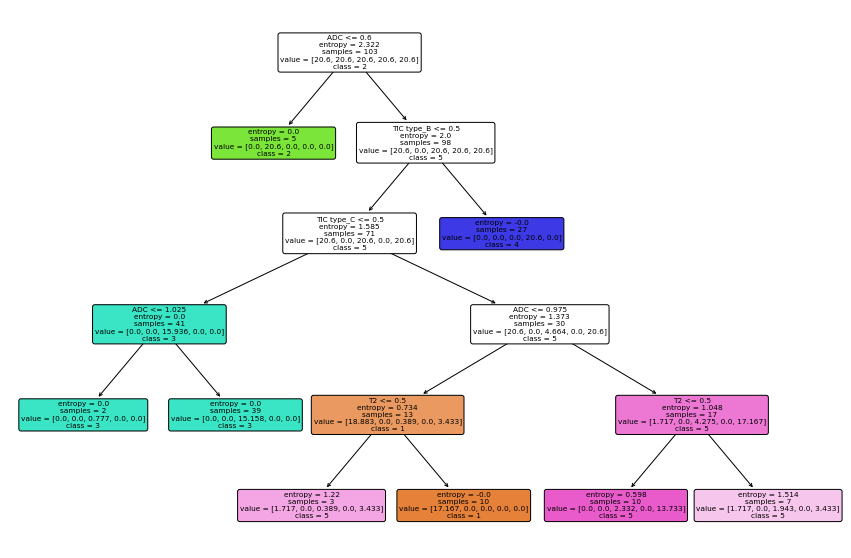

In [30]:
clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 5, min_samples_leaf = 2,
                                  class_weight = 'balanced', criterion = 'entropy')
clf = clf.fit(X,y)

plt.figure(figsize=(15,10))
tree.plot_tree(clf,
               feature_names = features,
               class_names = classes, filled = True, rounded = True)


[Text(283.98214285714283, 504.7714285714286, 'ADC <= 0.6\nentropy = 2.322\nsamples = 103\nvalue = [20.6, 20.6, 20.6, 20.6, 20.6]\nclass = 2'),
 Text(224.19642857142856, 427.11428571428576, 'entropy = 0.0\nsamples = 5\nvalue = [0.0, 20.6, 0.0, 0.0, 0.0]\nclass = 2'),
 Text(343.7678571428571, 427.11428571428576, 'TIC type_B <= 0.5\nentropy = 2.0\nsamples = 98\nvalue = [20.6, 0.0, 20.6, 20.6, 20.6]\nclass = 5'),
 Text(283.98214285714283, 349.4571428571429, 'TIC type_C <= 0.5\nentropy = 1.585\nsamples = 71\nvalue = [20.6, 0.0, 20.6, 0.0, 20.6]\nclass = 5'),
 Text(119.57142857142857, 271.8, 'ADC <= 1.025\nentropy = 0.0\nsamples = 41\nvalue = [0.0, 0.0, 15.936, 0.0, 0.0]\nclass = 3'),
 Text(59.785714285714285, 194.14285714285717, 'entropy = 0.0\nsamples = 2\nvalue = [0.0, 0.0, 0.777, 0.0, 0.0]\nclass = 3'),
 Text(179.35714285714286, 194.14285714285717, 'entropy = 0.0\nsamples = 39\nvalue = [0.0, 0.0, 15.158, 0.0, 0.0]\nclass = 3'),
 Text(448.3928571428571, 271.8, 'ADC <= 0.975\nentropy = 1.3

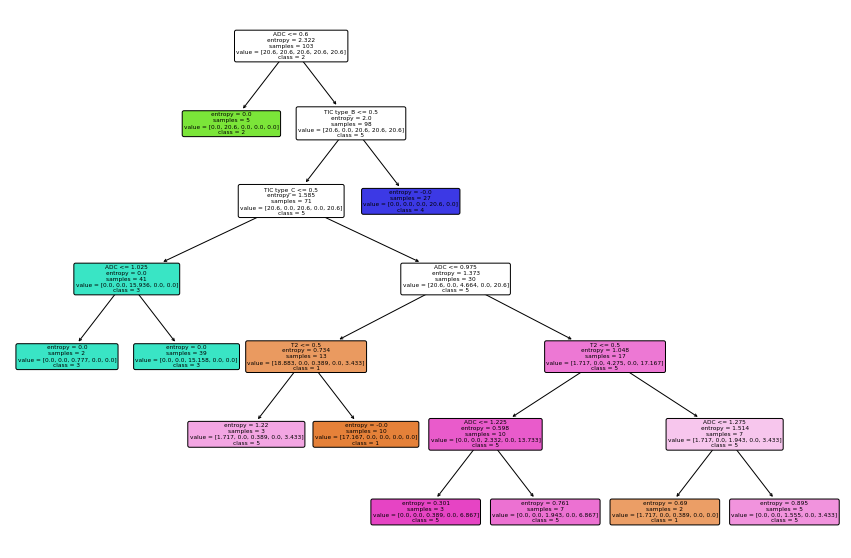

In [31]:
clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 6, min_samples_leaf = 2,
                                  class_weight = 'balanced', criterion = 'entropy')
clf = clf.fit(X,y)

plt.figure(figsize=(15,10))
tree.plot_tree(clf,
               feature_names = features,
               class_names = classes, filled = True, rounded = True)


In [47]:
#ora vorrei misurare le performance dei decision tree
#Faccio una cross validation stratificata a 5 fold e calcolo l'accuratezza media e la dev std
#5 fold così almeno la fold usata per il test contiene un rtappresentante della classe 5 e della classe 2
from sklearn import tree
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
import numpy as np
import graphviz


seed = 17

scoring = make_scorer(accuracy_score)

clf = tree.DecisionTreeClassifier(random_state = seed, criterion = 'entropy',
                                     max_depth = 5, min_samples_leaf = 2, class_weight = 'balanced')

cv = StratifiedKFold(shuffle = True, n_splits = 5, random_state = seed)

scores = cross_val_score(clf, X, y, cv = cv, scoring = scoring)
print(scores)
print('Acc: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))

[0.80952381 0.85714286 0.80952381 0.85       0.8       ]
Acc: 0.825
Std dev: 0.024


In [48]:
scoring = make_scorer(f1_score, average = 'weighted')#è macro che tiene conto di label imbalancement

scores = cross_val_score(clf, X, y, cv = cv, scoring = scoring)
print(scores)
print('Acc: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))

[0.85185185 0.8887218  0.82698413 0.82857143 0.82509804]
Acc: 0.844
Std dev: 0.024


In [40]:
#uso test size 0.2 stratificato così almeno il test set contiene un rappresentante della classe 2 e della classe 5
#provo altro approccio

for n in range(10):
    clf = tree.DecisionTreeClassifier(random_state = seed, criterion = 'entropy',
                                     max_depth = 4, min_samples_leaf = 2, class_weight = 'balanced')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,
                                                        random_state = None, shuffle = True)
    
    clf = clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division = 0))
    print('-'*80)
    

              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         1
           3       1.00      0.82      0.90        11
           4       1.00      1.00      1.00         6
           5       0.33      1.00      0.50         1

    accuracy                           0.86        21
   macro avg       0.60      0.76      0.64        21
weighted avg       0.89      0.86      0.86        21

--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         2
           2       0.00      0.00      0.00         1
           3       0.90      0.82      0.86        11
           4       1.00      1.00      1.00         6
           5       0.00      0.00      0.00         1

    accuracy                           0.81        21
   macro avg       0.48      0.56      0.50       

In [35]:
#ora uso grid search per trovare l'albero ottimo e lo stampo
from sklearn.model_selection import GridSearchCV

In [58]:
tuned_parameters = {'criterion':['entropy'],
                   'max_depth': list(range(2,9)),
                   'min_samples_leaf': list(range(2,6)),
                   'class_weight':['balanced', None]}

cv = StratifiedKFold(shuffle = True, n_splits = 5, random_state = None)
scoring = make_scorer(accuracy_score)
scores = []
for n in range(10):
    
    clf = tree.DecisionTreeClassifier(random_state = None)
    
    clf = GridSearchCV(clf, tuned_parameters, scoring = scoring, cv = cv, refit = True )
    clf.fit(X,y)
    print(clf.best_params_)
    print(clf.best_score_)
    scores.append(clf.best_score_)


print('Acc: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
0.8738095238095239
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8466666666666667
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
0.8838095238095238
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8652380952380951
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8638095238095238
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
0.8542857142857143
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8638095238095238
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
0.8552380952380952
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8733333333333333
{'class_weight': None, 'criterion': 'entropy', 'max_dep

In [59]:
tuned_parameters = {'criterion':['entropy'],
                   'max_depth': list(range(2,9)),
                   'min_samples_leaf': list(range(2,6)),
                   'class_weight':['balanced', None]}

cv = StratifiedKFold(shuffle = True, n_splits = 5, random_state = None)
scoring = make_scorer(f1_score, average = 'weighted')
scores = []
for n in range(10):
    
    clf = tree.DecisionTreeClassifier(random_state = None)
    clf = GridSearchCV(clf, tuned_parameters, scoring = scoring, cv = cv, refit = True )
    clf.fit(X,y)
    print(clf.best_params_)
    print(clf.best_score_)
    scores.append(clf.best_score_)


print('f1: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8531290545203589
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.859079245733381
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
0.8523791777580596
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
0.8526125317056993
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8530730553090802
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3}
0.8654177109440268
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.842612244897959
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
0.8548800923878324
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3}
0.8368554720133667
{'class_weight': None, 'criterion

In [60]:
tuned_parameters = {'criterion':['entropy'],
                   'max_depth': list(range(2,9)),
                   'min_samples_leaf': list(range(2,6)),
                   'class_weight':['balanced']}

cv = StratifiedKFold(shuffle = True, n_splits = 5, random_state = None)
scoring = make_scorer(accuracy_score)
scores = []
for n in range(10):
    clf = tree.DecisionTreeClassifier(random_state = None)
    clf = GridSearchCV(clf, tuned_parameters, scoring = scoring, cv = cv, refit = True )
    clf.fit(X,y)
    print(clf.best_params_)
    print(clf.best_score_)
    scores.append(clf.best_score_)


print('Acc: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8447619047619048
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}
0.8452380952380952
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8161904761904761
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2}
0.8347619047619048
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8357142857142857
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3}
0.8347619047619048
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}
0.8361904761904763
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
0.8161904761904764
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8247619047619047
{

In [61]:
tuned_parameters = {'criterion':['entropy'],
                   'max_depth': list(range(2,9)),
                   'min_samples_leaf': list(range(2,6)),
                   'class_weight':['balanced']}

cv = StratifiedKFold(shuffle = True, n_splits = 5, random_state = None)
scoring = make_scorer(f1_score, average = 'weighted')
scores = []
for n in range(10):
    
    clf = tree.DecisionTreeClassifier(random_state = None)
    
   
    
    clf = GridSearchCV(clf, tuned_parameters, scoring = scoring, cv = cv, refit = True )
    clf.fit(X,y)
    print(clf.best_params_)
    print(clf.best_score_)
    scores.append(clf.best_score_)


print('f1: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
0.8309075817461486
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
0.8165099979385694
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8331207336735865
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}
0.8489921906214812
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3}
0.86045408552437
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8381464773043721
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8510115765604487
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3}
0.8393613000755857
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
0.8641934106976124
{'c

[Text(494.5909090909091, 475.65000000000003, 'TIC type_B <= 0.5\nentropy = 1.812\nsamples = 103\nvalue = [12, 5, 53, 27, 6]\nclass = 3'),
 Text(304.3636363636364, 339.75, 'ADC <= 0.925\nentropy = 1.202\nsamples = 73\nvalue = [12, 2, 53, 0, 6]\nclass = 3'),
 Text(152.1818181818182, 203.85000000000002, 'ADC <= 0.6\nentropy = 1.372\nsamples = 16\nvalue = [11, 2, 2, 0, 1]\nclass = 1'),
 Text(76.0909090909091, 67.94999999999999, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2, 0, 0, 0]\nclass = 2'),
 Text(228.27272727272728, 67.94999999999999, 'entropy = 0.946\nsamples = 14\nvalue = [11, 0, 2, 0, 1]\nclass = 1'),
 Text(456.54545454545456, 203.85000000000002, 'TIC type_C <= 0.5\nentropy = 0.554\nsamples = 57\nvalue = [1, 0, 51, 0, 5]\nclass = 3'),
 Text(380.4545454545455, 67.94999999999999, 'entropy = 0.0\nsamples = 40\nvalue = [0, 0, 40, 0, 0]\nclass = 3'),
 Text(532.6363636363636, 67.94999999999999, 'entropy = 1.166\nsamples = 17\nvalue = [1, 0, 11, 0, 5]\nclass = 3'),
 Text(684.8181818181819, 

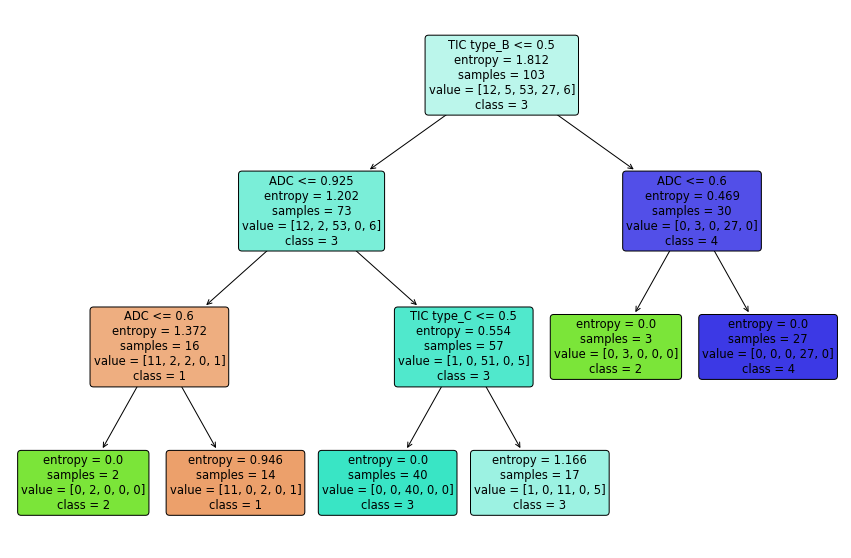

In [38]:
#visualizzo il master tree che non bilancia le classi emerso vittorioso dalla GridSearch
clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 3, min_samples_leaf = 2,
                                   criterion = 'entropy')
clf = clf.fit(X,y)

plt.figure(figsize=(15,10))
tree.plot_tree(clf,
               feature_names = features,
               class_names = classes, filled = True, rounded = True)


In [39]:
#so
#quest'ultimo albero è meno profondo di quelli bilanciati che sembrano offrire una setacciatura combarabile,
#inoltre commette un solo caso di falso negativo

#gli alberi che bilanciano le classi classificano i maligni come 5 fino a profondità 3. a 4 sembra commettere solo un
#falso negativo, e presenta regole simile all'albero di profodnità 3 sovrastante. Anche in questo caso
#vengono prese in considerazione solo ADC e TIC type. Solo gli alberi con classi bilanciate a profondità >= 5 impiegano
#anche T2, senza però un significativo aumento dell'accuratezza (come testimoniato dalla gridsearch)

#cosa fare quindi?
#automatizzare in maniera più fine il processo di estrazione dell'albero ottimo, verificare la stabilità del modello
#includere SMOTE e SMOTENC
#vedere come alberi con classi bilanciate e non cambiano filtrando da principio i maligni con segni malignità = 1

In [71]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [82]:
#uso smotenc facendo una cross validation iterata con i parametri ottimali ottenuti 

categorical_features = [0,2,3,4,5]

#per ora sampling strategy = auto
smt = SMOTENC(k_neighbors = 3, random_state=None, categorical_features=categorical_features,
              sampling_strategy = 'minority')
      
#ogni iterazione faccio una cv diversa
for n in range(10):
    
    clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 5, criterion = 'entropy',
                                      min_samples_leaf = 2, class_weight = 'balanced' )
    
    skf = StratifiedKFold( shuffle = True, n_splits = 5, random_state = None)
    
    scores = []
    
    for train_index, test_index in skf.split(X,y):
        
        X_train, y_train, X_test, y_test = (X.iloc[train_index], y.iloc[train_index],
                                            X.iloc[test_index], y.iloc[test_index] )
        for i in range(4):
            X_train, y_train = smt.fit_resample(X_train, y_train)

        clf = clf.fit(X_train, y_train)
        
        #qui posso calcolare direttamente l'accuratezza perchè con l'aumentation le classi sono bilanciate
        
        accuracy = clf.score(X_test, y_test)
        
        scores.append(accuracy)
        
    print('Mean Accuracy: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))
    print('-'*80)
    



Mean Accuracy: 0.854
Std dev: 0.054
--------------------------------------------------------------------------------
Mean Accuracy: 0.826
Std dev: 0.048
--------------------------------------------------------------------------------
Mean Accuracy: 0.816
Std dev: 0.062
--------------------------------------------------------------------------------
Mean Accuracy: 0.855
Std dev: 0.042
--------------------------------------------------------------------------------
Mean Accuracy: 0.855
Std dev: 0.051
--------------------------------------------------------------------------------
Mean Accuracy: 0.854
Std dev: 0.030
--------------------------------------------------------------------------------
Mean Accuracy: 0.814
Std dev: 0.076
--------------------------------------------------------------------------------
Mean Accuracy: 0.845
Std dev: 0.034
--------------------------------------------------------------------------------
Mean Accuracy: 0.845
Std dev: 0.036
----------------------------

In [83]:
categorical_features = [0,2,3,4,5]

#per ora sampling strategy = auto
smt = SMOTENC(k_neighbors = 3, random_state=None, categorical_features=categorical_features,
              sampling_strategy = 'minority')
      
#ogni iterazione faccio una cv diversa
for n in range(10):
    
    clf = tree.DecisionTreeClassifier(random_state = seed, max_depth = 3, criterion = 'entropy',
                                      min_samples_leaf = 2 )
    
    skf = StratifiedKFold( shuffle = True, n_splits = 5, random_state = None)
    
    scores = []
    
    for train_index, test_index in skf.split(X,y):
        
        X_train, y_train, X_test, y_test = (X.iloc[train_index], y.iloc[train_index],
                                            X.iloc[test_index], y.iloc[test_index] )
        for i in range(4):
            X_train, y_train = smt.fit_resample(X_train, y_train)

        clf = clf.fit(X_train, y_train)
        
        #qui posso calcolare direttamente l'accuratezza perchè con l'aumentation le classi sono bilanciate
        
        accuracy = clf.score(X_test, y_test)
        
        scores.append(accuracy)
        
    print('Mean Accuracy: %0.3f\nStd dev: %0.3f' %(np.mean(scores), np.std(scores)))
    print('-'*80)
    

Mean Accuracy: 0.825
Std dev: 0.066
--------------------------------------------------------------------------------
Mean Accuracy: 0.755
Std dev: 0.181
--------------------------------------------------------------------------------
Mean Accuracy: 0.727
Std dev: 0.137
--------------------------------------------------------------------------------
Mean Accuracy: 0.778
Std dev: 0.075
--------------------------------------------------------------------------------
Mean Accuracy: 0.760
Std dev: 0.201
--------------------------------------------------------------------------------
Mean Accuracy: 0.776
Std dev: 0.066
--------------------------------------------------------------------------------
Mean Accuracy: 0.826
Std dev: 0.048
--------------------------------------------------------------------------------
Mean Accuracy: 0.796
Std dev: 0.056
--------------------------------------------------------------------------------
Mean Accuracy: 0.735
Std dev: 0.182
----------------------------